In [1]:
import numpy as np
import yt
import matplotlib.pyplot as plt
from field_definitions import _nuclei_density, _electron_density
from matplotlib.colors import LogNorm
import pickle
from astropy import units as u, constants  as const

pc = const.pc.cgs.value
kB  = const.k_B.cgs.value
Msun = const.M_sun.cgs.value
G = const.G.cgs.value
Myr = u.Myr.in_units("s")

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "text.latex.preamble" : r'\boldmath'
})


In [2]:
# radius of the bubble and center
radius=120
# c = ([-80, -150, 0], "pc") # only new version of YT
c = [-80*pc, -150*pc, 0*pc]

yt : [INFO     ] 2025-02-21 08:44:14,739 Parameters: current_time              = 340597785179995.1
yt : [INFO     ] 2025-02-21 08:44:14,741 Parameters: domain_dimensions         = [8 8 8]
yt : [INFO     ] 2025-02-21 08:44:14,742 Parameters: domain_left_edge          = [-7.715e+20 -7.715e+20 -7.715e+20]
yt : [INFO     ] 2025-02-21 08:44:14,744 Parameters: domain_right_edge         = [7.715e+20 7.715e+20 7.715e+20]
yt : [INFO     ] 2025-02-21 08:44:14,744 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2025-02-21 08:44:22,101 Loading emissivity data from /Users/girichidis/Physics/Tables/yt-python/apec_emissivity_v3.h5
yt : [INFO     ] 2025-02-21 08:44:22,104 X-ray emissivity data calculated with APEC 3.0.9 on 11/19/2019 by John ZuHone.
yt : [INFO     ] 2025-02-21 08:44:22,105 X-ray 'apec' emissivity data version: 3.
yt : [INFO     ] 2025-02-21 08:44:22,123 Adding ('gas','xray_emissivity_0.1_2_keV') field.
yt : [INFO     ] 2025-02-21 08:44:22,124 Adding ('gas','xray_luminosity_

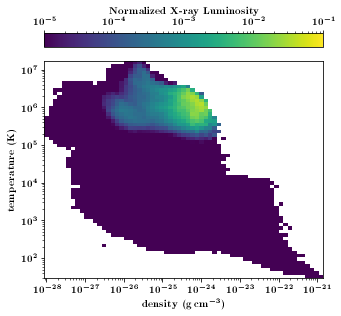

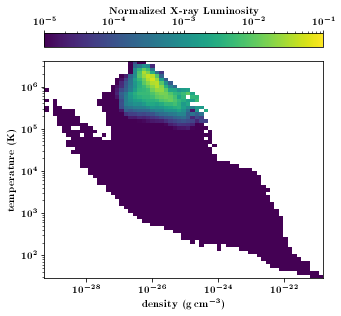

In [4]:
for default_file in ["SILCC_hdf5_plt_cnt_1080", "SILCC_hdf5_plt_cnt_1140"]:

    ds = yt.load("sim-files/"+default_file)
    # register data fields
    ds.add_field(('gas', 'H_nuclei_density'), _nuclei_density, sampling_type="local", units="cm**(-3)", force_override=True)
    ds.add_field(('gas', 'electron_density'), _electron_density, sampling_type="local", units="g*cm**(-3)", force_override=True)
    ds.add_field(('gas', 'El_number_density'), _nuclei_density, sampling_type="local", units="cm**(-3)", force_override=True)

    yt.add_xray_emissivity_field(ds, 0.1, 2, metallicity=1.0, \
                                 data_dir="/Users/girichidis/Physics/Tables/yt-python/", table_type="apec")


    sphere = ds.sphere(c, (radius, "pc"))

    tot_lum = sphere[("gas", "xray_luminosity_0.1_2_keV")].v.sum()

    density = sphere[("gas", "density")].to("g/cm**3").v
    temperature = sphere[("gas", "temperature")].to("K").v
    xray_luminosity = sphere[("gas", "xray_luminosity_0.1_2_keV")].v / tot_lum

    density_bins = np.logspace(np.log10(density.min()), np.log10(density.max()), 64)
    temperature_bins = np.logspace(np.log10(temperature.min()), np.log10(temperature.max()), 64)

    hist, xedges, yedges = np.histogram2d(density, temperature, bins=[density_bins, temperature_bins], weights=xray_luminosity)


    # plot dens-temp-emission
    fig, ax = plt.subplots(figsize=(5,5))
    X, Y = np.meshgrid(xedges, yedges)
    im = ax.pcolormesh(X, Y, hist.T, shading='auto', cmap='viridis', norm=LogNorm(vmin=1e-5, vmax=1e-1))
    cbar = plt.colorbar(im, label='\\textbf{Normalized X-ray Luminosity}', orientation="horizontal", location="top")

    #ax.imshow(hist.T, origin="lower", extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]], norm=LogNorm())
    ax.set_aspect("auto")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("\\textbf{density }$(\\mathrm{g}\\,\\mathrm{cm}^{-3})$")
    ax.set_ylabel("\\textbf{temperature }$(\\mathrm{K})$")
    fig.savefig("plots/"+default_file+"-dens-temp-emission.pdf", bbox_inches="tight")


    # maps with contour lines
    # get emission
    emissivity_field = ("gas", "xray_emissivity_0.1_2_keV")
    vmin = 2
    vmax = 7.5

    p_emissivity = yt.SlicePlot(ds, "z", center=c, fields=emissivity_field)
    p_emissivity.set_zlim(emissivity_field, vmin, vmax)

    frb_emissivity = p_emissivity.data_source.to_frb((2*radius, 'pc'), 1024)
    emissivity_data = frb_emissivity[emissivity_field]

    total_emission = np.sum(emissivity_data)

    sorted_emissivity_data = np.sort(emissivity_data.flatten())[::-1]
    cumsum_emissivity = np.cumsum(sorted_emissivity_data)
    threshold_95 = sorted_emissivity_data[np.argmax(cumsum_emissivity >= 0.95 * total_emission)]
    threshold_90 = sorted_emissivity_data[np.argmax(cumsum_emissivity >= 0.90 * total_emission)]
    threshold_80 = sorted_emissivity_data[np.argmax(cumsum_emissivity >= 0.80 * total_emission)]

    mask_95 = emissivity_data >= threshold_95
    mask_90 = emissivity_data >= threshold_90
    mask_80 = emissivity_data >= threshold_80

    # also store the masks
    masks = {}
    masks[80] = mask_80
    masks[90] = mask_90
    masks[95] = mask_95

    # store in pickle
    with open("datafiles/"+default_file+"-emission-contours.pkl", 'wb') as handle:
        pickle.dump(masks, handle)

In [5]:
# extract density and temperature from previously computed data
dens = np.load("datafiles/SILCC_hdf5_plt_cnt_1080-dens.npy")
temp = np.load("datafiles/SILCC_hdf5_plt_cnt_1080-temp.npy")

46.30859364873623 -29.19921872974723


<ipython-input-6-9fe0042dc5e2>:22: UserWarning: The following kwargs were not used by contour: 'label'
  contour_95 = ax.contour(mask_95, levels=[0.5], colors='red', linewidths=2, extent=extent, label='95% Emissivity')
<ipython-input-6-9fe0042dc5e2>:23: UserWarning: The following kwargs were not used by contour: 'label'
  contour_90 = ax.contour(mask_90, levels=[0.5], colors='orange', linewidths=2, extent=extent, label='90% Emissivity')
<ipython-input-6-9fe0042dc5e2>:24: UserWarning: The following kwargs were not used by contour: 'label'
  contour_80 = ax.contour(mask_80, levels=[0.5], colors='yellow', linewidths=2, extent=extent, label='80% Emissivity')
<ipython-input-6-9fe0042dc5e2>:44: UserWarning: The following kwargs were not used by contour: 'label'
  contour_95 = ax.contour(mask_95, levels=[0.5], colors='C0', linewidths=2, extent=extent, label='95% Emissivity')
<ipython-input-6-9fe0042dc5e2>:45: UserWarning: The following kwargs were not used by contour: 'label'
  contour_90 = a

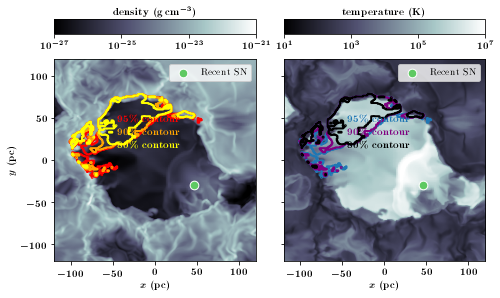

In [6]:
##### create a plot for two fields with contours

extent = [-radius, radius, -radius, radius]

# recent SN
point_x = (-1.03971680e+20 / 3.086e+18 + 80)
point_y = (-5.53008789e+20 / 3.086e+18 + 150)
print(point_x, point_y)

fig = plt.figure(figsize=(7,7))

ax = fig.add_axes([0,0,0.4,0.4])
im = ax.imshow(dens, cmap="bone", origin="lower", \
                           extent=extent, norm=LogNorm(vmin=1e-27, vmax=1e-21))
ax.set_xlabel("$x~(\\mathrm{pc})$")
ax.set_ylabel("$y~(\\mathrm{pc})$")

cbar_axes = fig.add_axes([0.0,0.45,0.4,0.03])
cbar = plt.colorbar(im, cax=cbar_axes, orientation="horizontal", label="\\textbf{density }$(\\mathrm{g}\\,\\mathrm{cm}^{-3})$")
cbar.ax.xaxis.set_label_position("top")

contour_95 = ax.contour(mask_95, levels=[0.5], colors='red', linewidths=2, extent=extent, label='95% Emissivity')
contour_90 = ax.contour(mask_90, levels=[0.5], colors='orange', linewidths=2, extent=extent, label='90% Emissivity')
contour_80 = ax.contour(mask_80, levels=[0.5], colors='yellow', linewidths=2, extent=extent, label='80% Emissivity')
ax.text(-45,45, '\\textbf{95\\% contour}', color="red")
ax.text(-45,30, '\\textbf{90\\% contour}', color="orange")
ax.text(-45,15, '\\textbf{80\\% contour}', color="yellow")

# plot SN
ax.scatter(point_x, point_y, color='#5ec962', s=75, marker="o", \
           edgecolor='white', label='Recent SN', zorder=100)
ax.legend()

ax = fig.add_axes([0.455,0.0,0.4,0.4])
ax.set_yticklabels([])
im = ax.imshow(temp, cmap="bone", origin="lower", \
                           extent=extent, norm=LogNorm(vmin=10, vmax=1e7))
ax.set_xlabel("$x~(\\mathrm{pc})$")

cbar_axes = fig.add_axes([0.455,0.45,0.4,0.03])
cbar = plt.colorbar(im, cax=cbar_axes, orientation="horizontal", label="\\textbf{temperature }$(\\mathrm{K})$")
cbar.ax.xaxis.set_label_position("top")

contour_95 = ax.contour(mask_95, levels=[0.5], colors='C0', linewidths=2, extent=extent, label='95% Emissivity')
contour_90 = ax.contour(mask_90, levels=[0.5], colors='purple', linewidths=2, extent=extent, label='90% Emissivity')
contour_80 = ax.contour(mask_80, levels=[0.5], colors='black', linewidths=2, extent=extent, label='80% Emissivity')


ax.text(-45,45, '\\textbf{95\\% contour}', color="C0")
ax.text(-45,30, '\\textbf{90\\% contour}', color="purple")
ax.text(-45,15, '\\textbf{80\\% contour}', color="black")

# plot SN
ax.scatter(point_x, point_y, color='#5ec962', s=75, marker="o", \
           edgecolor='white', label='Recent SN', zorder=100)
ax.legend()

fig.savefig("plots/dens-temp-with-contours.pdf", bbox_inches="tight")